#### SVI data Analysis for Tennessee

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('./data/SVI data/SVI2020_US_county.gdb')

In [4]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['TN'])]

In [5]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

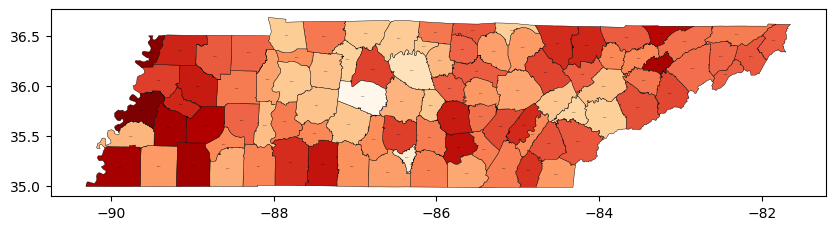

In [6]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [7]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [8]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.2,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ..."
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.2,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ..."
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.2,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ..."


#### Overdose data (2020)
we need to combine Overdose data to the svi dataframe

In [9]:

# this contains mortality data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
mortality_df = pd.read_csv('./data/Mortality data/Current Final Multiple Cause of Death Data/TennesseeDeaths_2018_2021.csv')

In [10]:
# rename county code column to FIPS
mortality_df.rename(columns={'County Code':'FIPS'}, inplace=True)

In [11]:
# convert FIPS column to string
mortality_df['FIPS'] = mortality_df['FIPS'].astype(str)

In [12]:
# filtering the mortality data for year 2020
mortality_df_2020 = mortality_df[mortality_df['Year']==2020]
mortality_df_2020.reset_index(drop=True, inplace=True)

In [13]:
mortality_df_2020.head(3)

,State,County,FIPS,Year,Year Code,Deaths,Population,Crude Rate
0,TN,"Anderson County, TN",47001,2020,2020,63,77558,81.2
1,TN,"Bedford County, TN",47003,2020,2020,16,50179,Unreliable
2,TN,"Benton County, TN",47005,2020,2020,Suppressed,16131,Suppressed


In [14]:
# Assuming filtered_df has the 'od_deaths' column
od_deaths_counts = mortality_df_2020['Deaths'].value_counts()

# Print the counts of each unique value in the 'od_deaths' column
print(od_deaths_counts)

Suppressed    35
14             6
10             5
17             4
13             3
0              3
16             3
12             3
38             2
33             2
23             2
63             2
41             2
22             2
94             1
31             1
48             1
24             1
71             1
461            1
56             1
133            1
43             1
66             1
34             1
11             1
35             1
350            1
20             1
29             1
18             1
141            1
21             1
448            1
79             1
Name: Deaths, dtype: int64


In [15]:
# Merge the dataframes on the 'FIPS' column(this will include all the 2020 data for the Washington DC, Virginia, Maryland, and West Virginia(county level))
merged_df_TN = pd.merge(filtered_svi_df, mortality_df_2020[['FIPS', 'Deaths']],
                     on='FIPS', how='left')

In [16]:

# Rename the 'Provisional Drug Overdose Deaths' column to 'od_deaths'
# merged_df.rename(columns={'Provisional Drug Overdose Deaths': 'od_deaths'}, inplace=True)

# If there are NaN values in 'od_deaths' column, you can fill them with a default value, for example, 0
# merged_df['Deaths'].fillna(0, inplace=True)

# Now, merged_df contains the new column 'od_deaths' based on matching FIPS codes

In [17]:
merged_df_TN.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ...",63
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ...",16
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ...",Suppressed


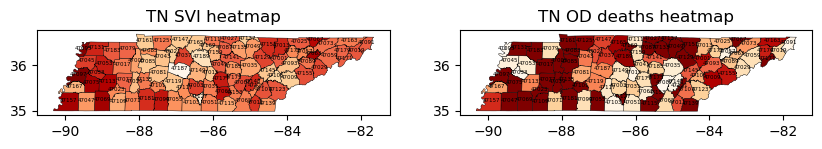

In [18]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = merged_df_TN.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('TN SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = merged_df_TN.plot(ax=axes[1], column="Deaths", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('TN OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in merged_df_TN.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

In [19]:
# make "Suppressed" values in the Deaths column to 5   
merged_df_TN['Deaths'].replace('Suppressed', 5, inplace=True)

In [20]:
# check the data type of the Deaths column
print(type(merged_df_TN['Deaths'][0]))

<class 'str'>


In [21]:
# convert Deaths column to float
merged_df_TN['Deaths'] = merged_df_TN['Deaths'].astype(float)

In [22]:
# create a new column 'od_deaths_per_1000' which is the ratio of 'od_deaths' to 'E_TOTPOP' and multiply by 1000
merged_df_TN['od_deaths_per_1000'] = (merged_df_TN['Deaths']/merged_df_TN['E_TOTPOP'])*1000

In [23]:
TN_svi_deaths = merged_df_TN

#### Now we need to select the socioeconmics variables and deaths data to create a prediction model to find most important variables
'E_TOTPOP','EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_NOINT','EP_AFAM','EP_HISP','EP_ASIAN','EP_AIAN','EP_NHPI','EP_TWOMORE','EP_OTHERRACE','od_deaths_per_1000'

##### Socioeconomic variables
###### EP_POV150    Percentage of persons below 150% poverty estimate
###### EP_UNEMP    Unemployment Rate estimate
###### EP_HBURD    Percentage of housing cost-burdened occupied housing units with annual income less than $75,000 (30%+ of income spent on housing costs) estimate, 2016-2020 ACS estimate, 2016-2020 ACS
###### EP_NOHSDP   Percentage of persons with no high school diploma (age 25+) estimate
###### EP_UNINSUR  Percentage uninsured in the total civilian noninstitutionalized population estimate, 2016-2020 ACS

In [24]:
# socioeconomic variable into a list
socioeconomic_variable_names = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR']

In [25]:
# filter metro_svi_deaths dataframe to include only the socioeconomic variables and od_deaths_per_1000
tn_svi_deaths_socioeconomic = merged_df_TN[socioeconomic_variable_names + ['od_deaths_per_1000']]

In [26]:
tn_svi_deaths_socioeconomic.head()

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,od_deaths_per_1000
0,24.6,5.5,22.4,11.4,8.9,0.823389
1,24.6,4.4,24.7,16.5,11.3,0.326951
2,31.7,7.2,18.8,16.6,7.7,0.309924
3,27.8,7.5,13.5,21.6,16.4,0.000000
4,18.6,4.8,20.0,10.6,9.2,0.501364


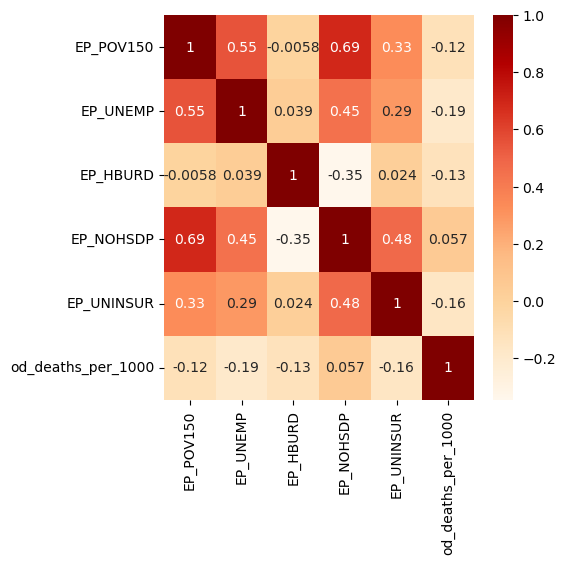

In [27]:
# create a correlation matrix
corr_matrix = tn_svi_deaths_socioeconomic.corr()

# plot the correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')   
plt.show()

#### Taking all the variables

In [28]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','od_deaths_per_1000']

In [29]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

In [30]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
tnSviMultipleVariablesDf = TN_svi_deaths[selectedVariables]

In [31]:
# create X and y
X = tnSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = tnSviMultipleVariablesDf['od_deaths_per_1000']

#### Checking whether relationships in this datset are linear or not

Calculate the correlation coefficient (e.g., Pearson correlation) between each feature and the target variable. A high absolute value of the correlation coefficient suggests a stronger linear relationship.

In [33]:
correlation_matrix = tnSviMultipleVariablesDf.corr()
correlation_with_target = correlation_matrix['od_deaths_per_1000']

In [34]:
correlation_with_target

EP_POV150            -0.115707
EP_UNEMP             -0.193119
EP_HBURD             -0.127327
EP_NOHSDP             0.056782
EP_UNINSUR           -0.158094
EP_AGE65              0.051185
EP_AGE17              0.035244
EP_DISABL            -0.046061
EP_SNGPNT            -0.227268
EP_LIMENG            -0.054410
EP_MINRTY            -0.250897
EP_MUNIT              0.105739
EP_MOBILE             0.077288
EP_CROWD              0.063324
EP_NOVEH             -0.165621
EP_GROUPQ            -0.258585
od_deaths_per_1000    1.000000
Name: od_deaths_per_1000, dtype: float64

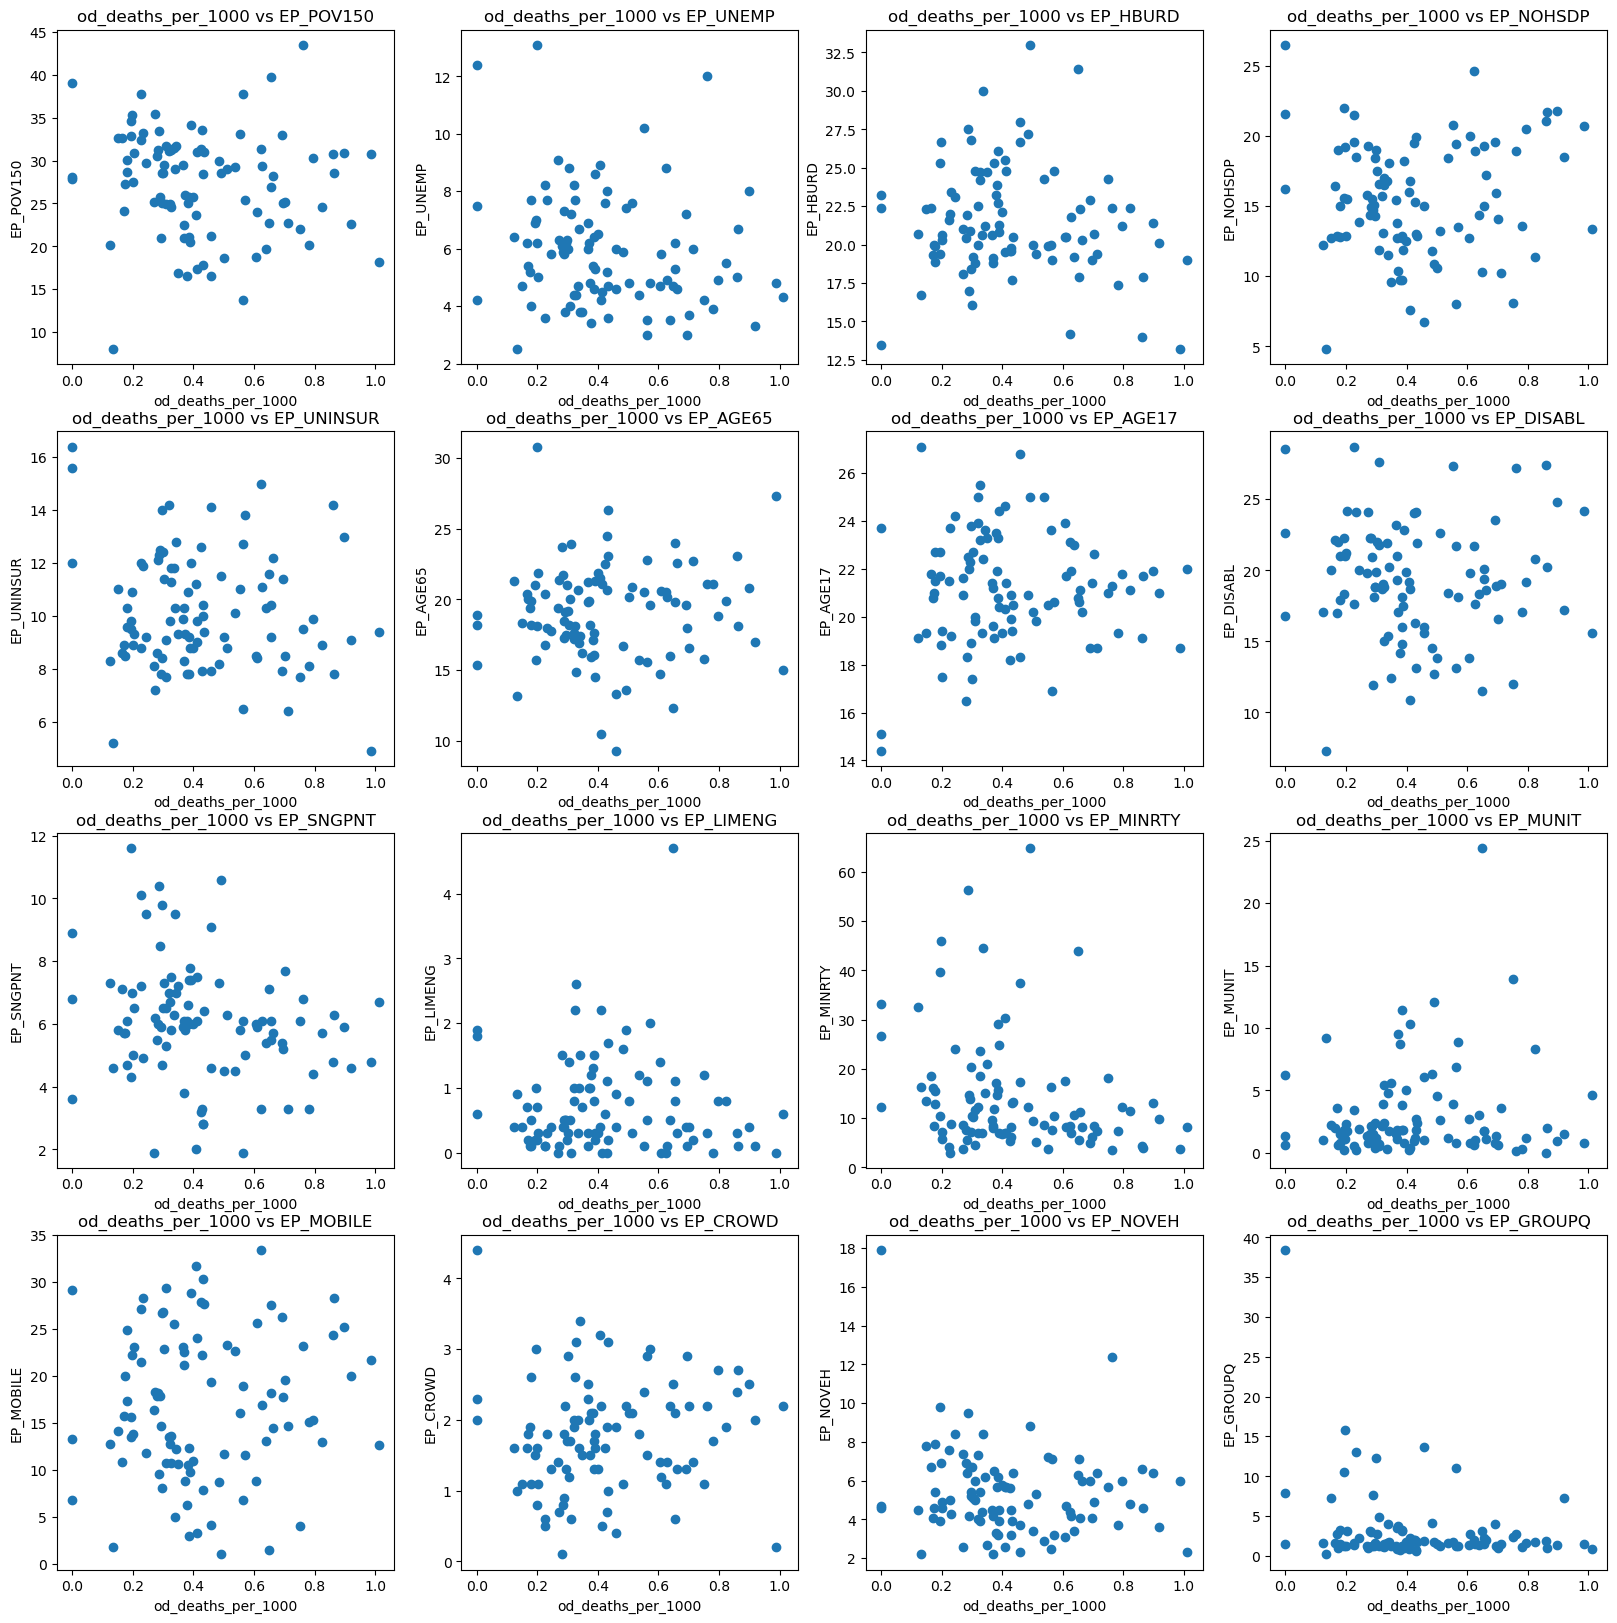

In [35]:
# plot scatter plot for all the variables
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for idx, var in enumerate(selectedVariablesWithoutY):
    axes[idx//4, idx%4].scatter(tnSviMultipleVariablesDf['od_deaths_per_1000'], tnSviMultipleVariablesDf[var])
    axes[idx//4, idx%4].set_xlabel('od_deaths_per_1000')
    axes[idx//4, idx%4].set_ylabel(var)
    axes[idx//4, idx%4].set_title('od_deaths_per_1000 vs ' + var)

plt.show()

### Feature Selection Methods

### I. Filter feature selection methods

#### Measure the pearson correlation between the variables

In [36]:
#define spear,am correlation function
from scipy.stats import spearmanr

target_variable = "od_deaths_per_1000"

# Calculate Spearman's correlation for each variable
correlation_results = {}
for column in tnSviMultipleVariablesDf.columns:
    if column != target_variable:
        coef, p = spearmanr(tnSviMultipleVariablesDf[column], tnSviMultipleVariablesDf[target_variable])
        correlation_results[column] = abs(coef)

# Sort variables based on absolute correlation coefficient in descending order
sorted_variables = sorted(correlation_results, key=correlation_results.get, reverse=True)

# Print the list of variables and their correlation coefficients
print(f"Variables sorted by absolute correlation with '{target_variable}':")
for variable in sorted_variables:
    print(f"{variable}: {correlation_results[variable]:.2f}")

Variables sorted by absolute correlation with 'od_deaths_per_1000':
EP_MINRTY: 0.29
EP_SNGPNT: 0.24
EP_UNEMP: 0.21
EP_POV150: 0.20
EP_CROWD: 0.17
EP_NOVEH: 0.16
EP_DISABL: 0.13
EP_GROUPQ: 0.12
EP_HBURD: 0.09
EP_UNINSUR: 0.09
EP_MOBILE: 0.06
EP_MUNIT: 0.06
EP_AGE65: 0.04
EP_LIMENG: 0.04
EP_NOHSDP: 0.01
EP_AGE17: 0.01


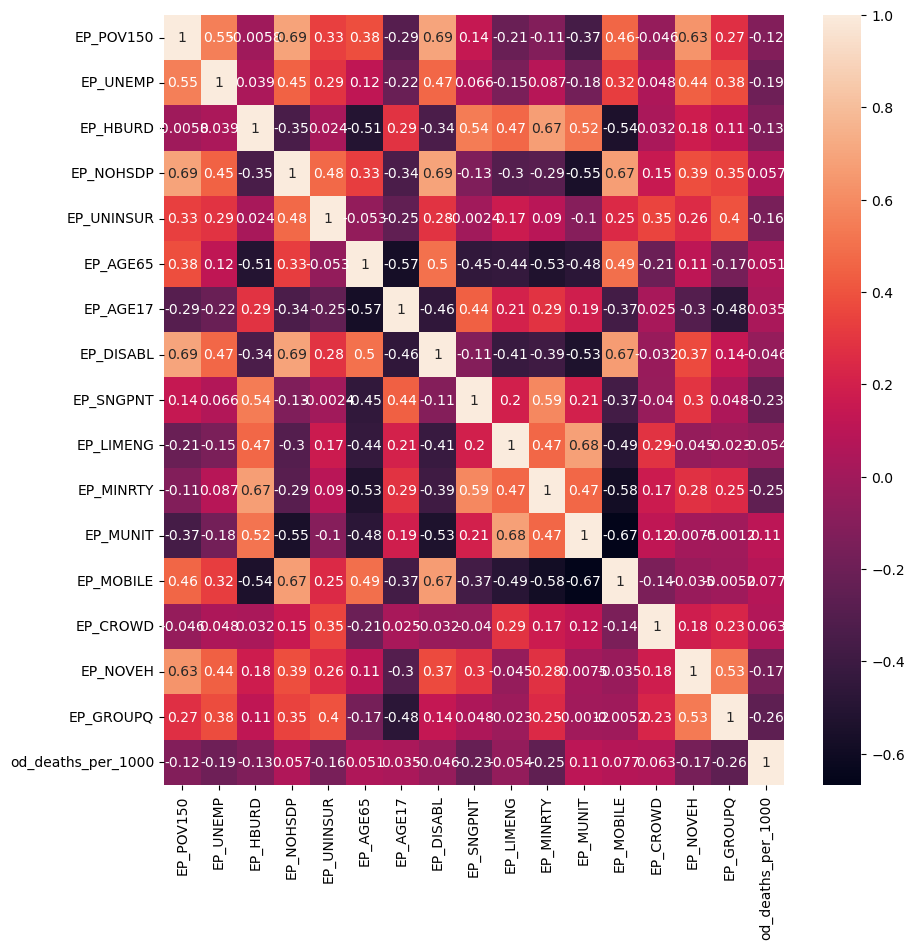

In [37]:
# measure the pearson correlation between the variables
from scipy.stats import pearsonr

# calculate Pearson's correlation matrix   
corr_matrix = tnSviMultipleVariablesDf.corr()

# plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### When nonlinear relations are expected we employ Spearman’s Rho	

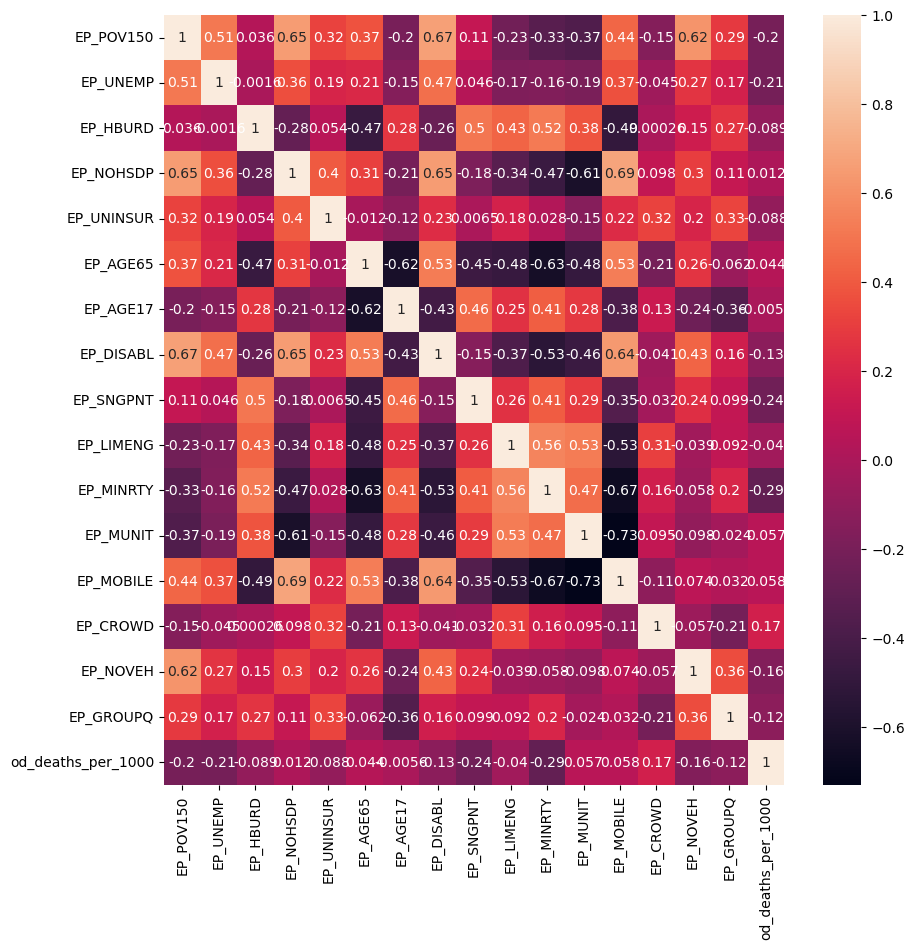

In [38]:
# calculate Spearman’s Rho	
from scipy.stats import spearmanr

# calculate spearman's correlation
coef, p = spearmanr(tnSviMultipleVariablesDf)
# print('Spearmans correlation coefficient: %.3f' % coef)

#plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(coef, annot=True, xticklabels=tnSviMultipleVariablesDf.columns, yticklabels=tnSviMultipleVariablesDf.columns)
plt.show()

Statistical tests can be used to select those features that have the strongest relationship with the output variable. Here we are going to use chi-squared (chi²) statistical test for non-negative features to select 10 of the best features.

#### f_regression statistical test

###### Type of Metric: F-statistic
###### Nature of Relationship: Linear
###### Use Case: Best suited for identifying linear relationships between individual features and the target variable. It is based on the assumption that the relationship between features and the target variable is linear.
###### Output: Provides a score for each feature based on the F-statistic, which indicates how well the feature contributes to the linear regression model.

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [40]:
# create X and y
X = tnSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = tnSviMultipleVariablesDf['od_deaths_per_1000']

In [41]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [42]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [43]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

         Specs     Score
15   EP_GROUPQ  6.664182
10   EP_MINRTY  6.247563
8    EP_SNGPNT  5.065141
1     EP_UNEMP  3.602811
14    EP_NOVEH  2.622966
4   EP_UNINSUR  2.384002
2     EP_HBURD  1.532586
0    EP_POV150  1.261982
11    EP_MUNIT  1.051575
12   EP_MOBILE  0.558870


#### mutual_info_regression statistical test

###### Type of Metric: Mutual Information
###### Nature of Relationship: Non-linear and Non-parametric
###### Use Case: Captures any type of statistical dependency, including non-linear relationships. It does not assume a specific form of relationship and can identify complex associations between features and the target variable.
###### Output: Provides a score for each feature based on mutual information, which measures the amount of information one variable (feature) contains about another (target variable).

In [44]:
# Using mutual_info_regression
bestfeatures_mi = SelectKBest(score_func=mutual_info_regression, k=10)
fit_mi = bestfeatures_mi.fit(X, y.ravel())
dfscores_mi = pd.DataFrame(fit_mi.scores_)
dfcolumns_mi = pd.DataFrame(X.columns)
featureScores_mi = pd.concat([dfcolumns_mi, dfscores_mi], axis=1)
featureScores_mi.columns = ['Features', 'Score (mutual_info_regression)']

In [45]:
print(featureScores_mi.nlargest(10, 'Score (mutual_info_regression)'))

     Features  Score (mutual_info_regression)
3   EP_NOHSDP                        0.185286
8   EP_SNGPNT                        0.136899
14   EP_NOVEH                        0.105166
12  EP_MOBILE                        0.086083
0   EP_POV150                        0.053438
10  EP_MINRTY                        0.047126
6    EP_AGE17                        0.029429
15  EP_GROUPQ                        0.021785
7   EP_DISABL                        0.015714
13   EP_CROWD                        0.014533


### II. Wrapper feature selection methods

#### 1. Forward Feature Selection

In [51]:
#forward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [52]:
# create X and y
X = tnSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = tnSviMultipleVariablesDf['od_deaths_per_1000']

In [53]:
# calling the linear regression model

lreg = LinearRegression()
sfs1 = SFS(lreg, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')

In [54]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.7s finished

[2023-11-27 17:36:50] Features: 1/4 -- score: -0.04803833290148465[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished

[2023-11-27 17:36:51] Features: 2/4 -- score: -0.04702457719637879[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2023-11-27 17:36:52] Features: 3/4 -- score: -0.04629015011760351[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

In [55]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['EP_NOHSDP', 'EP_MINRTY', 'EP_MUNIT', 'EP_GROUPQ']


In [56]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[3, 10, 11, 15]


#### 2. Backward Feature Selection

In [57]:
# calling the linear regression model

lreg = LinearRegression()
sfs2 = SFS(lreg, k_features=4, forward=False, verbose=2, scoring='neg_mean_squared_error')

In [58]:
sfs2 = sfs2.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.7s finished

[2023-11-27 17:44:25] Features: 15/4 -- score: -0.05426348536257675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished

[2023-11-27 17:44:25] Features: 14/4 -- score: -0.051429704084963314[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s finished

[2023-11-27 17:44:26] Features: 13/4 -- score: -0.04986715784088201[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]:

In [59]:
feat_names = list(sfs2.k_feature_names_)
print(feat_names)

['EP_NOHSDP', 'EP_DISABL', 'EP_MUNIT', 'EP_GROUPQ']


### III. Embedded feature selection method

#### Lasso regression

In [60]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [61]:
# create X and y
X = tnSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = tnSviMultipleVariablesDf['od_deaths_per_1000']

In [62]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [63]:
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (76, 16)
Shape of Test Features: (19, 16)
Shape of Train Target: (76,)
Shape of Test Target: (19,)


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train[selectedVariablesWithoutY])
X_test_std = scaler.transform(X_test[selectedVariablesWithoutY])

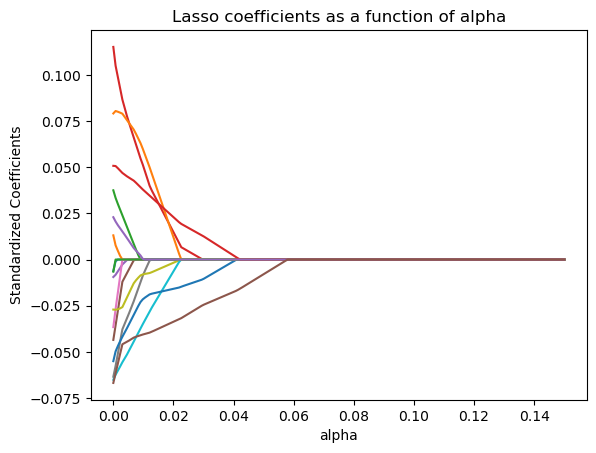

In [65]:
alphas = np.linspace(0.00001,0.15,200)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
# ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

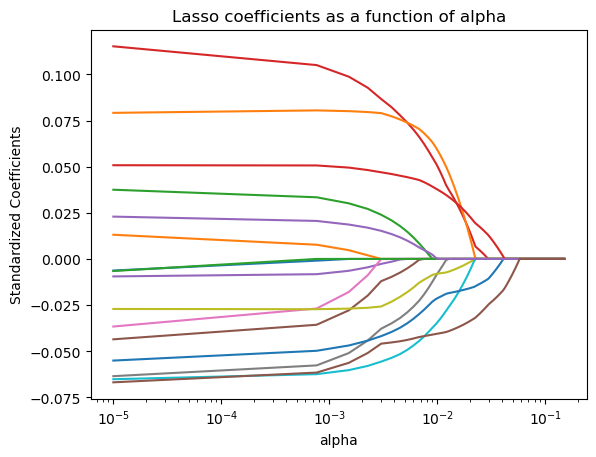

In [66]:
alphas = np.linspace(0.00001,0.15,200)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_std, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [67]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 0.15, 500)}

In [68]:
# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

In [69]:
# Initializing the Model
lasso = Lasso()

In [70]:
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [71]:
names=tnSviMultipleVariablesDf.drop("od_deaths_per_1000", axis=1).columns

In [72]:
#Using Lasso Regressor to plot the best features.

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

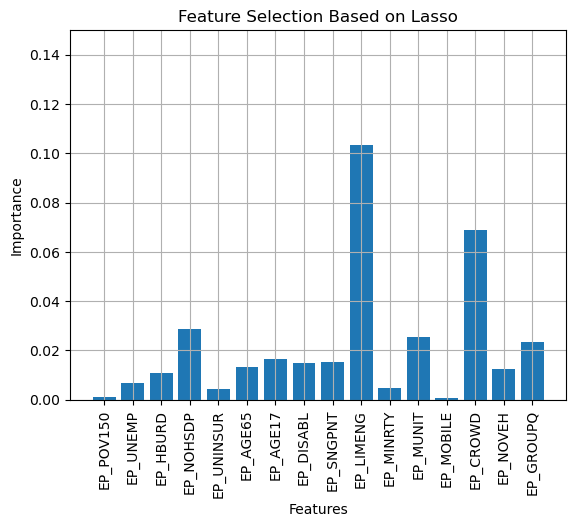

In [73]:
# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [74]:
# Use argsort to get the indices that would sort the array
sorted_indices = np.argsort(lasso1_coef)

# Reverse the indices to get them in descending order (high importance to low importance)
sorted_indices = sorted_indices[::-1]

# Create a list of tuples with variable names and coefficients
sorted_vars_and_coefs = [(names[i], lasso1_coef[i]) for i in sorted_indices]

# If you want to get the original indices (feature indices) in the order of importance
original_feature_indices = sorted_indices

# Print or use sorted_vars_and_coefs and original_feature_indices as needed
for var_name, coef in sorted_vars_and_coefs:
    print(f"Variable: {var_name}, Coefficient: {coef}")

# If you want to access a specific variable or coefficient, you can use indexing
# For example, to get the most important variable and its coefficient:
most_important_variable = sorted_vars_and_coefs[0][0]
most_important_coefficient = sorted_vars_and_coefs[0][1]
print(f"Most Important Variable: {most_important_variable}, Coefficient: {most_important_coefficient}")

Variable: EP_LIMENG, Coefficient: 0.10358038081781601
Variable: EP_CROWD, Coefficient: 0.06893274757194531
Variable: EP_NOHSDP, Coefficient: 0.028812964738298683
Variable: EP_MUNIT, Coefficient: 0.025482935950206873
Variable: EP_GROUPQ, Coefficient: 0.023526802095760913
Variable: EP_AGE17, Coefficient: 0.016652083897562946
Variable: EP_SNGPNT, Coefficient: 0.015401005179778292
Variable: EP_DISABL, Coefficient: 0.0150214274264414
Variable: EP_AGE65, Coefficient: 0.013409324439161412
Variable: EP_NOVEH, Coefficient: 0.012496098441096457
Variable: EP_HBURD, Coefficient: 0.010945638333753577
Variable: EP_UNEMP, Coefficient: 0.006663536928700746
Variable: EP_MINRTY, Coefficient: 0.004581345452012503
Variable: EP_UNINSUR, Coefficient: 0.0045300082017158995
Variable: EP_POV150, Coefficient: 0.00106369664956573
Variable: EP_MOBILE, Coefficient: 0.0008384763249527989
Most Important Variable: EP_LIMENG, Coefficient: 0.10358038081781601
